In [1]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2, os
from natsort import natsorted

from src.scripts.models.Pix2Vox import Encoder, Decoder, Merger, Refiner
from src.scripts import data_transforms
from config import cfg

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else: device = 'cpu'

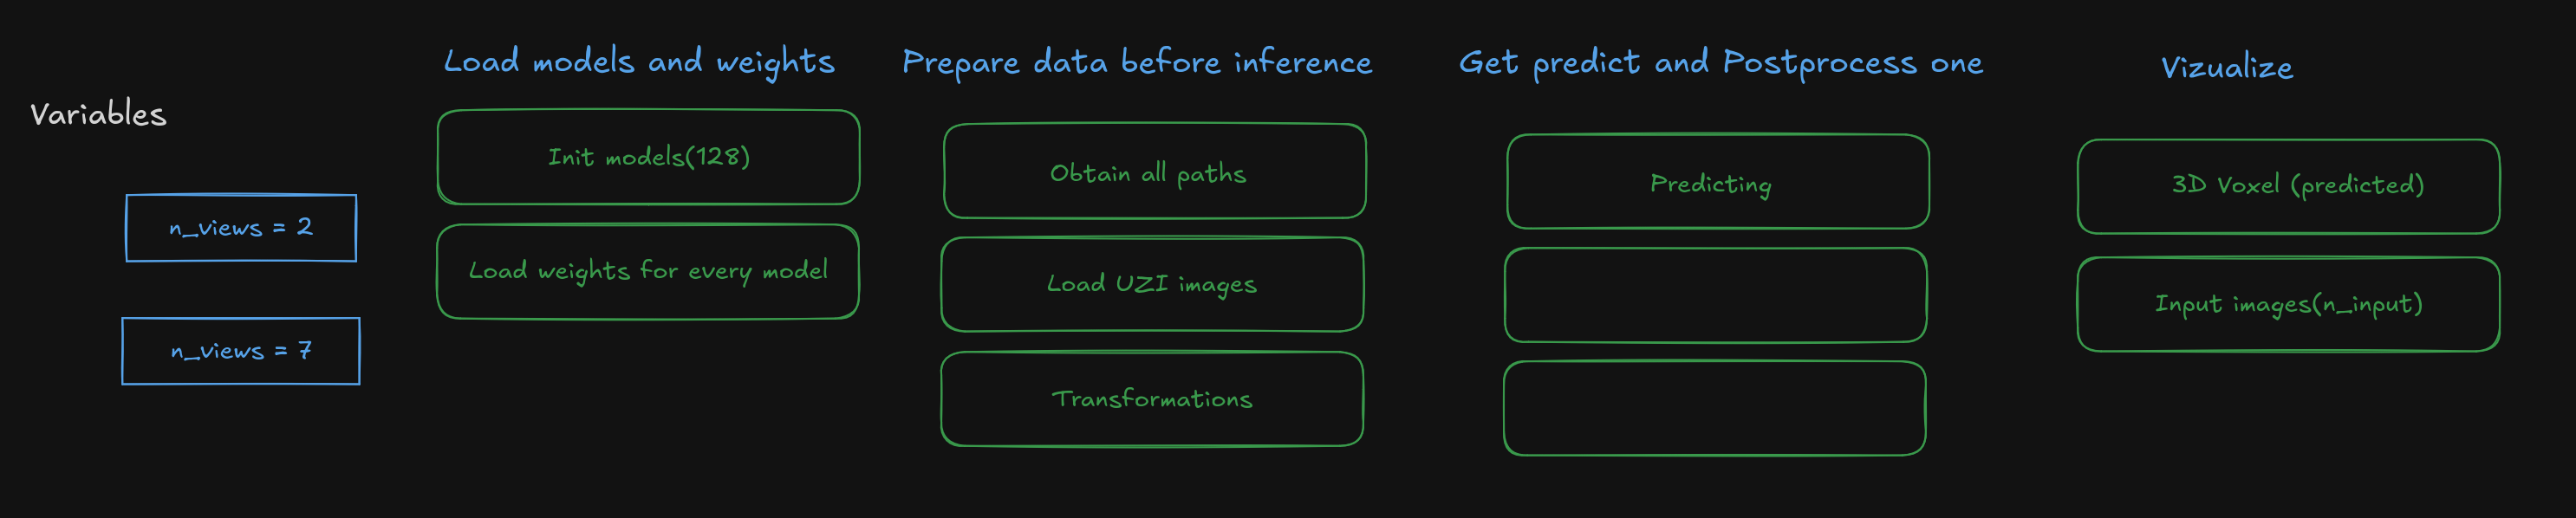

# 1.Load models
## 1.1 Init models

In [4]:
N_VIEWS = 7  # 2
if N_VIEWS == 7:
    folder = '128_all'
elif N_VIEWS == 2:
    folder = '128_4ch_2ch'
else:
    print("")

# Set up data augmentation
IMG_SIZE = cfg.CONST.IMG_H, cfg.CONST.IMG_W
# CROP_SIZE = cfg.CONST.CROP_IMG_H, cfg.CONST.CROP_IMG_W

model_path = f'models/{folder}/checkpoint-best.pth'

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def init_weights(m):
    if type(m) == torch.nn.Conv2d or type(m) == torch.nn.Conv3d or \
            type(m) == torch.nn.ConvTranspose2d or type(m) == torch.nn.ConvTranspose3d:
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif type(m) == torch.nn.BatchNorm2d or type(m) == torch.nn.BatchNorm3d:
        torch.nn.init.constant_(m.weight, 1)
        torch.nn.init.constant_(m.bias, 0)
    elif type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, 0, 0.01)
        torch.nn.init.constant_(m.bias, 0)

In [6]:
# Set up networks
encoder = Encoder(cfg).to(device)
decoder = Decoder(cfg).to(device)
refiner = Refiner(cfg).to(device)
merger = Merger(cfg).to(device)

print('Parameters in Encoder: %d.' % (count_parameters(encoder)))
print('Parameters in Decoder: %d.' % (count_parameters(decoder)))
print('Parameters in Refiner: %d.' % (count_parameters(refiner)))
print('Parameters in Merger: %d.' % (count_parameters(merger)))

Parameters in Encoder: 6298678.
Parameters in Decoder: 71714264.
Parameters in Refiner: 34959320.
Parameters in Merger: 8571.


In [7]:
# Initialize weights of networks
encoder.apply(init_weights)
decoder.apply(init_weights)
refiner.apply(init_weights)
merger.apply(init_weights)

Merger(
  (layer1): Sequential(
    (0): Conv3d(9, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (layer2): Sequential(
    (0): Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (layer3): Sequential(
    (0): Conv3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (layer4): Sequential(
    (0): Conv3d(4, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (layer5): Sequential(
    (0): Conv3d(2

In [8]:
if torch.cuda.is_available():
    encoder = torch.nn.DataParallel(encoder).cuda()
    decoder = torch.nn.DataParallel(decoder).cuda()
    refiner = torch.nn.DataParallel(refiner).cuda()
    merger = torch.nn.DataParallel(merger).cuda()

## 1.2 Load weights for every model

In [9]:
# if 'WEIGHTS' in cfg.CONST and cfg.TRAIN.RESUME_TRAIN:
    # print('[INFO] %s Recovering from %s ...' % (dt.now(), cfg.CONST.WEIGHTS))

checkpoint = torch.load(model_path)
init_epoch = checkpoint['epoch_idx']
best_iou = checkpoint['best_iou']
best_epoch = checkpoint['best_epoch']

encoder.load_state_dict(checkpoint['encoder_state_dict'])#, strict=False)
decoder.load_state_dict(checkpoint['decoder_state_dict'])#, strict=False)
if cfg.NETWORK.USE_REFINER:
    refiner.load_state_dict(checkpoint['refiner_state_dict'])#, strict=False)
if cfg.NETWORK.USE_MERGER:
    merger.load_state_dict(checkpoint['merger_state_dict'])#, strict=False)

/tmp/ipykernel_8364/4011453942.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [10]:
# 'module.resnet.5.3.bn3.num_batches_tracked', 'module.layer1.0.weight', 'module.layer1.0.bias'
# Split it?
checkpoint['encoder_state_dict']

OrderedDict([('module.resnet.0.weight',
              tensor([[[[-0.0997, -0.3509,  0.0207,  ...,  0.0847,  0.1360, -0.1079],
                        [-0.1106, -0.1098, -0.1679,  ...,  0.1046, -0.2335, -0.2048],
                        [-0.0305, -0.1479, -0.1729,  ...,  0.0914,  0.1349, -0.2084],
                        ...,
                        [ 0.0115, -0.0345,  0.0574,  ...,  0.0650, -0.1831,  0.1330],
                        [ 0.1794, -0.0137,  0.0444,  ..., -0.1581,  0.1005, -0.2434],
                        [-0.0425, -0.0403, -0.2195,  ..., -0.1618, -0.1776, -0.2007]],
              
                       [[-0.0643,  0.1261, -0.1033,  ..., -0.0189, -0.0263,  0.1941],
                        [ 0.1280,  0.0457, -0.1433,  ...,  0.1842, -0.1791, -0.0922],
                        [ 0.2713, -0.0968, -0.0632,  ...,  0.1894,  0.0537,  0.0453],
                        ...,
                        [-0.0064, -0.1741, -0.3148,  ...,  0.0622,  0.2709,  0.1498],
                        [-

# 2. Prepare data
##  2.1 Obtrain all paths of images

In [12]:
test_path = 'data/train/Heart/heart_seg/slices/full_heart_mesh_005'

imgs_paths = natsorted([ os.path.join(test_path, name) for name in os.listdir(test_path) ])
imgs_paths

['data/train/Heart/heart_seg/slices/full_heart_mesh_005/0.png',
 'data/train/Heart/heart_seg/slices/full_heart_mesh_005/1.png',
 'data/train/Heart/heart_seg/slices/full_heart_mesh_005/2.png',
 'data/train/Heart/heart_seg/slices/full_heart_mesh_005/3.png',
 'data/train/Heart/heart_seg/slices/full_heart_mesh_005/4.png',
 'data/train/Heart/heart_seg/slices/full_heart_mesh_005/5.png',
 'data/train/Heart/heart_seg/slices/full_heart_mesh_005/6.png',
 'data/train/Heart/heart_seg/slices/full_heart_mesh_005/7.png',
 'data/train/Heart/heart_seg/slices/full_heart_mesh_005/8.png']

## 2.2 Get Input images

In [13]:
def load_images(paths):
    assert isinstance(paths, list)
    assert isinstance(paths[0], str)

    images = []
    for path in paths:
        image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        image = image / 255
        images.append(image)

    return images

In [14]:
input_images = load_images(imgs_paths)
input_images = np.stack(input_images, axis=0)
input_images.shape

(9, 224, 224, 3)

## 2.3 Transform 

In [15]:
# 
train_transforms = data_transforms.Compose([
    # utils.data_transforms.RandomCrop(IMG_SIZE, CROP_SIZE),
    # utils.data_transforms.RandomBackground(cfg.TRAIN.RANDOM_BG_COLOR_RANGE),
    # data_transforms.ColorJitter(cfg.TRAIN.BRIGHTNESS, cfg.TRAIN.CONTRAST, cfg.TRAIN.SATURATION),
    # utils.data_transforms.RandomNoise(cfg.TRAIN.NOISE_STD),
    # data_transforms.Normalize(mean=cfg.DATASET.MEAN, std=cfg.DATASET.STD),
    # utils.data_transforms.RandomFlip(),
    # utils.data_transforms.RandomPermuteRGB(),
    data_transforms.ToTensor()
])
val_transforms = data_transforms.Compose([
    # utils.data_transforms.CenterCrop(IMG_SIZE, CROP_SIZE),
    # utils.data_transforms.RandomBackground(cfg.TEST.RANDOM_BG_COLOR_RANGE),
    # utils.data_transforms.ColorJitter(cfg.TRAIN.BRIGHTNESS, cfg.TRAIN.CONTRAST, cfg.TRAIN.SATURATION),
    # data_transforms.Normalize(mean=cfg.DATASET.MEAN, std=cfg.DATASET.STD),
    data_transforms.ToTensor()
])


In [16]:
inp_image = input_images.copy()
x = train_transforms(inp_image)      # torch.Size([9, 3, 224, 224])
x.shape

torch.Size([9, 3, 224, 224])

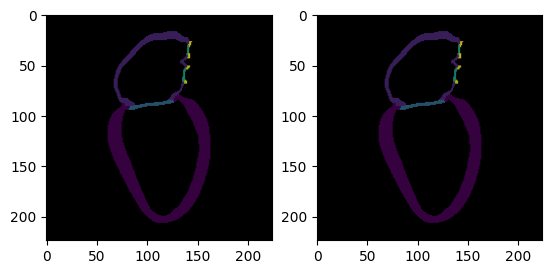

In [17]:
plt.subplot(121)
plt.imshow(input_images[8])
plt.subplot(122)
plt.imshow(np.permute_dims(x, (0, 2, 3, 1))[8])

# 3. Get predict and postprocess

In [19]:
# Switch models to evaluation mode
decoder.eval()
refiner.eval()
merger.eval()
encoder.eval()

DataParallel(
  (module): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
       

In [20]:
# Add batch
x = x.unsqueeze(0) 

In [21]:
is_gt = False


for images in [x]:
    with torch.no_grad():
        # Get data from data loader
        rendering_images = images.to(device)

        # Test the encoder, decoder, refiner and merger
        print(rendering_images.shape)
        image_features = encoder(rendering_images)
        raw_features, generated_volume = decoder(image_features)

        if cfg.NETWORK.USE_MERGER:
            generated_volume = merger(raw_features, generated_volume)

        if cfg.NETWORK.USE_MERGER:
            generated_volume = refiner(generated_volume)


        # IoU per sample
        if is_gt:
            ground_truth_volume = []
            # ...

            ground_truth_volume = ground_truth_volume.to(device)
            
            sample_iou = []
            for th in cfg.TEST.VOXEL_THRESH:
                _volume = torch.ge(generated_volume, th).float()
                intersection = torch.sum(_volume.mul(ground_truth_volume)).float()
                union = torch.sum(torch.ge(_volume.add(ground_truth_volume), 1)).float()
                sample_iou.append((intersection / union).item())


# mean_iou = []
# for taxonomy_id in best_iou:
#     test_iou[taxonomy_id]['iou'] = np.mean(test_iou[taxonomy_id]['iou'], axis=0)
#     mean_iou.append(test_iou[taxonomy_id]['iou'] * test_iou[taxonomy_id]['n_samples'])

#     ti = [taxonomy_id]['iou']
#     print('%.4f' % ti, end='\t')
# # 
# mean_iou = np.sum(mean_iou, axis=0) # / n_samples, we use 1 sample(one batch)

torch.Size([1, 9, 3, 224, 224])


In [22]:
generated_volume.shape

torch.Size([1, 128, 128, 128])

torch.Size([1, 128, 128, 128])


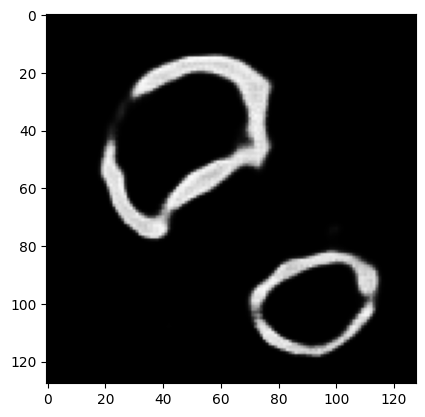

In [76]:
pred = generated_volume.detach().cpu()
print(pred.shape)
plt.imshow(pred[0][25] * 255, cmap='gray')
plt.show()

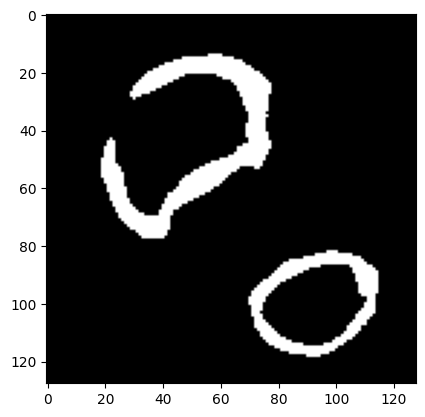

In [78]:
plt.imshow(np.where(pred[0][25] * 255 > 50, 255, 0), cmap='gray')

# 4. Visualize

In [24]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib import cm


def plot_3d_voxels(data, transparency_threshold=0, skew_factor=1, sampling_ratio=0.3, multi_view=True, colormap='magma',save_img=False ,channel_first=False):
    
    """
    This function visualizes 3D data (voxels) with one channel using a 3D scatter plot.

    Parameters:
    data (numpy.ndarray): A 4D numpy array representing the voxel grid.

    transparency_threshold (float): A threshold below which voxel values are considered transparent.

    skew_factor (float): A factor by which the voxel values are skewed before visualizing. 
                         This puts emphasis on higher values and suppresses lower ones. 
                         skewed_values = voxel_values ** skew_factor

    sampling_ratio (float): The ratio of non-zero voxels to sample and plot. Must be between 0 and 1.

    multi_view (boolean): Plot different views (perspective, top, bottom, front, left, right)

    colormap (string): The colormap of choice

    channel_first (boolean): Is the first dimension of your data the channel?

    save_img (boolean): Saves the plots as PDF and PNG. Change the path and file name to your liking.
    
    """

    # Check if the input data is a 4D numpy array
    if not isinstance(data, np.ndarray) or data.ndim != 4:
        raise ValueError("Input data must be a 4D numpy array")

    # Check if the transparency_threshold and skew_factor are valid numbers
    if not isinstance(transparency_threshold, (int, float)):
        raise ValueError("Transparency threshold must be a number")
    if not isinstance(skew_factor, (int, float)):
        raise ValueError("Skew factor must be a number")

    # Check if the sampling_ratio is a valid number between 0 and 1
    if not isinstance(sampling_ratio, (int, float)) or sampling_ratio < 0 or sampling_ratio > 1:
        raise ValueError("Sampling ratio must be a number between 0 and 1")

     # Reshape the data
    if channel_first==True:
        pass
    else:
        data = data.reshape((1, data.shape[0], data.shape[1], data.shape[2]))
     
        
    # Number of slices (z-dimension in the 3D space)
    num_slices = data.shape[-1]

    # Create figure and grid
    fig = plt.figure(figsize=(10, num_slices * 2))
    gs = gridspec.GridSpec(5, 3, height_ratios=[1] * 5, width_ratios=[1,3,1])
    ax_main = plt.subplot(gs[:, 1], projection='3d')

    # Create colormap and calculate color and transparency for non-zero voxels
    magma_cmap = cm.get_cmap(colormap)
    voxel_indices = np.argwhere(data > 0)
    voxel_values = data[data > 0] / np.max(data)
    
    # Random sampling of non-zero points
    sampled_indices = np.random.choice(np.arange(voxel_indices.shape[0]), size=int(voxel_indices.shape[0] * sampling_ratio), replace=False)
    voxel_indices = voxel_indices[sampled_indices]
    voxel_values = voxel_values[sampled_indices]

    #Skew the values for visualisatin
    skewed_values = voxel_values ** skew_factor
    
    colors = magma_cmap(skewed_values)
    colors[:, 3] = np.where(voxel_values > transparency_threshold, voxel_values, 0)

    # Plot the main 3D scatter plot
    ax_main.scatter(voxel_indices[:, 1], voxel_indices[:, 2], voxel_indices[:, 3], c=colors, marker='s')
    
    if multi_view==True:
        #Diffrent views 
        views = [
            {'title': 'Perspective View', 'elev': 30, 'azim': -45},
            {'title': 'Top View', 'elev': 90, 'azim': -95},
            {'title': 'Bottom View', 'elev': -90, 'azim': -95},
            {'title': 'Front View', 'elev': 5, 'azim': -85},
            {'title': 'Right View', 'elev': 5, 'azim': -20},
            {'title': 'Left View', 'elev': 5, 'azim': -160}
        ]

        # Plot the 3D different views scatter plot
        fig = plt.figure(figsize=(12, 12))
        for i, view in enumerate(views, start=1):
            ax = fig.add_subplot(2, 3, i, projection='3d')
            ax.scatter(voxel_indices[:, 1], voxel_indices[:, 2], voxel_indices[:, 3], c=colors, marker='s')
            ax.view_init(elev=view['elev'], azim=view['azim'])
            ax.set_title(view['title'])
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.grid(False)
            ax.xaxis.pane.set_edgecolor('k')
            ax.yaxis.pane.set_edgecolor('k')
            ax.zaxis.pane.set_edgecolor('k')

            ax.xaxis.pane.set_linewidth(2)
            ax.yaxis.pane.set_linewidth(2)
            ax.zaxis.pane.set_linewidth(2)       

            ax.xaxis.pane.fill = False
            ax.yaxis.pane.fill = False
            ax.zaxis.pane.fill = False

            # Set axes limits with a small margin
            ax.set_xlim(0, data.shape[1])
            ax.set_ylim(0, data.shape[2])
            ax.set_zlim(0, data.shape[3])
    
    
    # Tight layout and show the plot
    plt.tight_layout()
    
    # Save
    if save_img==True:
        #plt.savefig('Voxel.pdf')
        plt.savefig('Voxel.png', dpi=75)
    plt.show()
    

In [25]:
pred.numpy().shape

(1, 128, 128, 128)

/tmp/ipykernel_8364/1110905159.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  magma_cmap = cm.get_cmap(colormap)


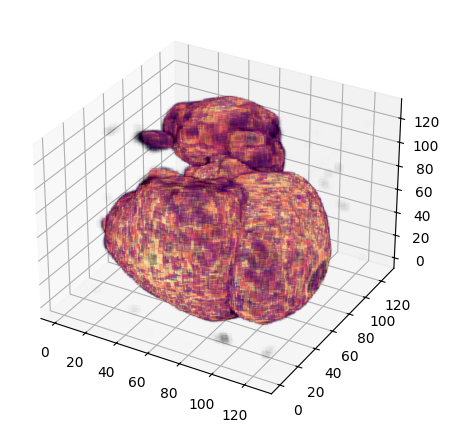

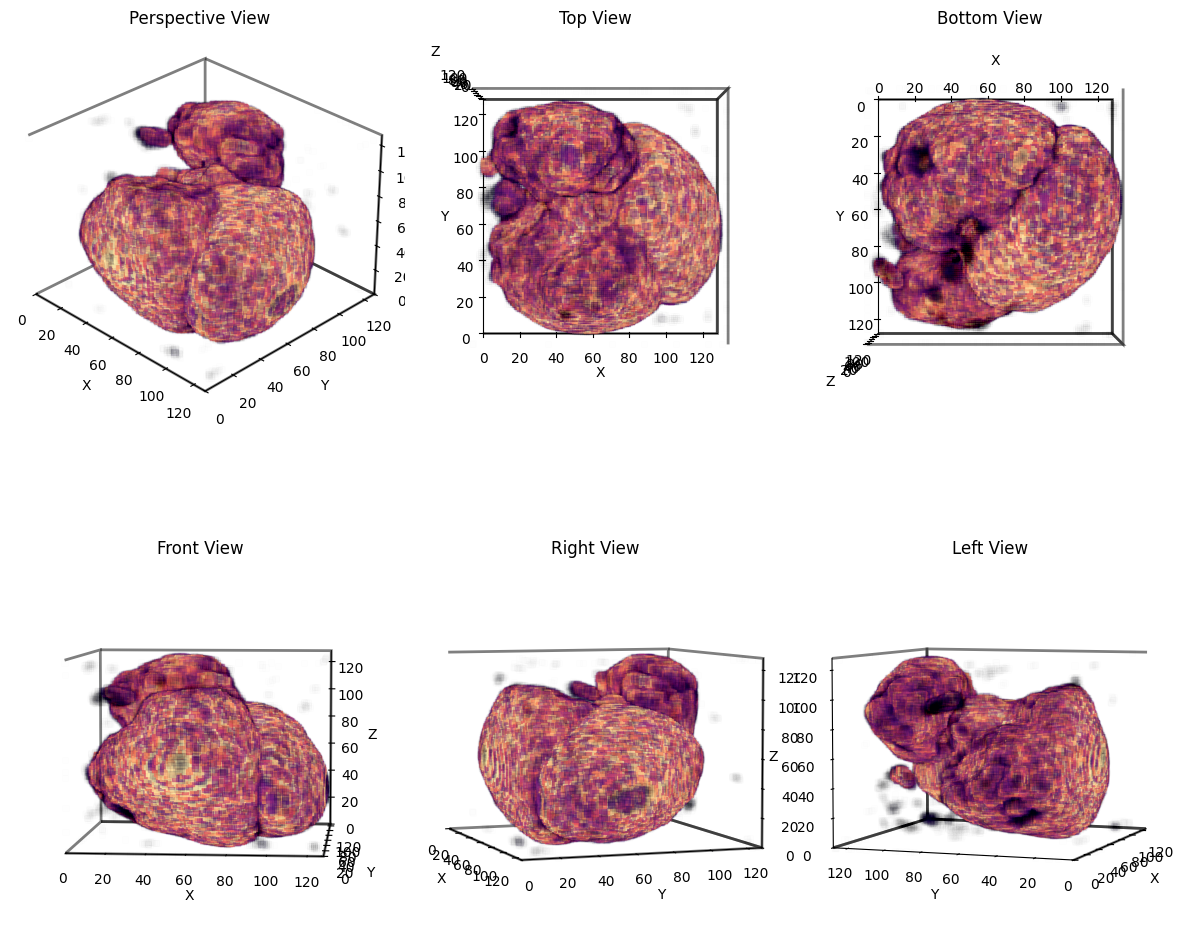

In [26]:
# 
plot_3d_voxels(pred.numpy().transpose(1, 2, 3, 0))

/tmp/ipykernel_8364/1110905159.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  magma_cmap = cm.get_cmap(colormap)


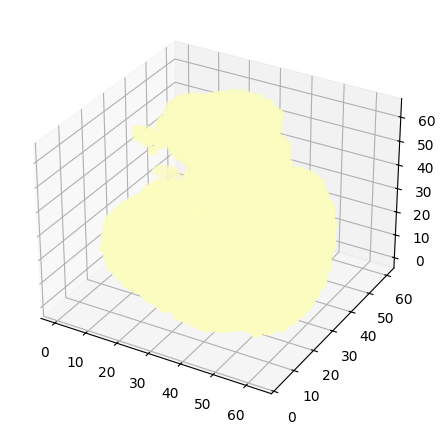

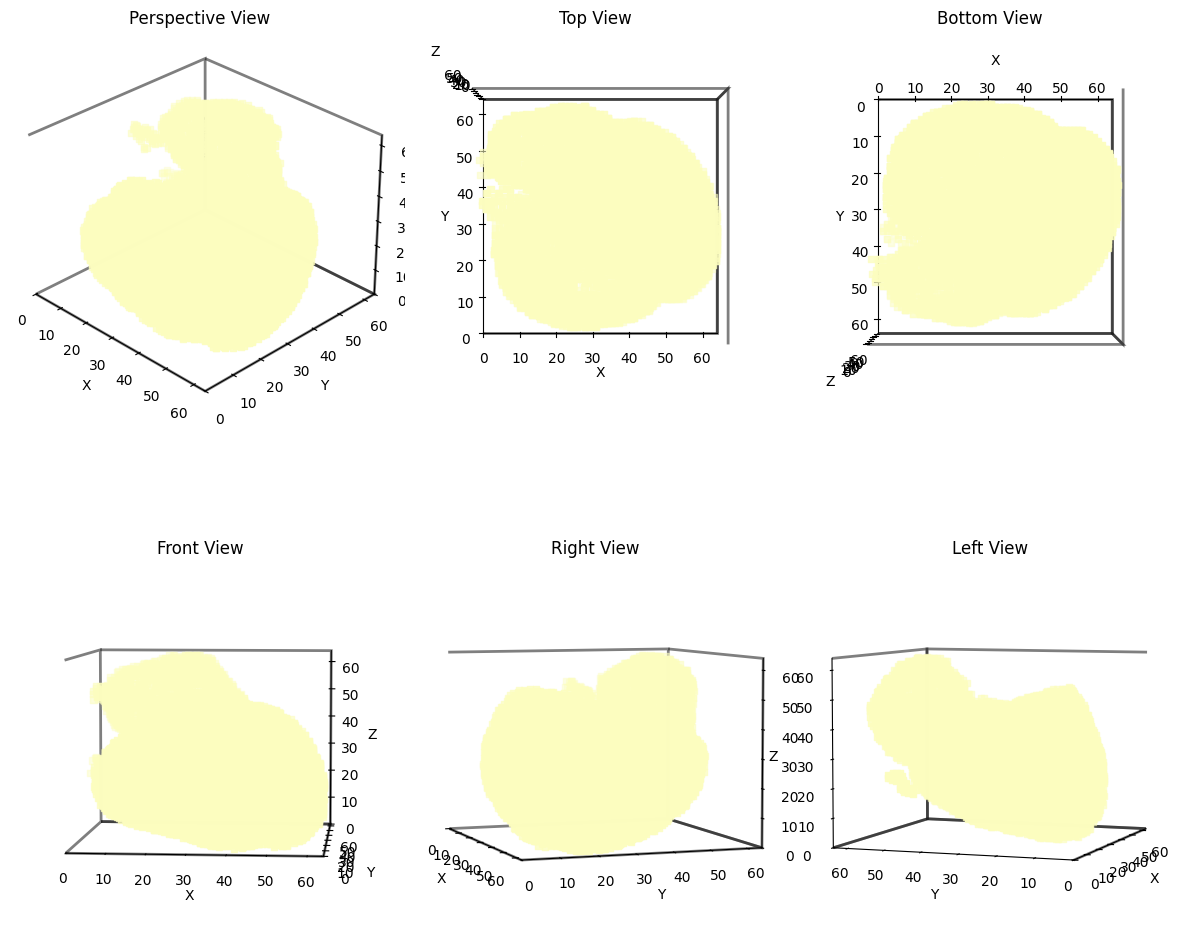

In [27]:
gt = np.load('data/train/Heart/heart_seg/voxels/full_heart_mesh_005/model.npy')
plot_3d_voxels(np.expand_dims(gt, -1))

In [28]:
gt.shape

(64, 64, 64)

# 5. Save

In [29]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure

In [30]:
trans_pred = pred.numpy()[0]
trans_pred.shape

(128, 128, 128)

In [31]:
verts, faces, normals, values = measure.marching_cubes(trans_pred)

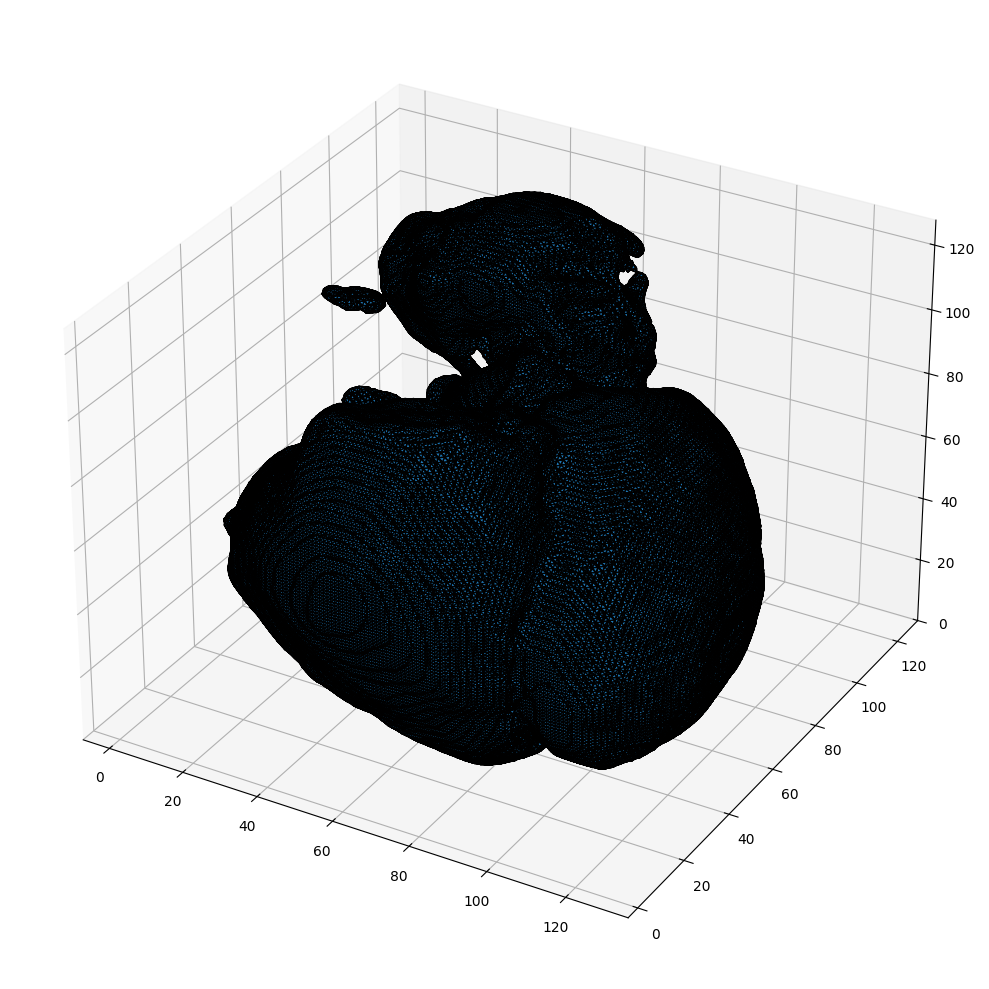

In [32]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

plt.tight_layout()
plt.show()

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


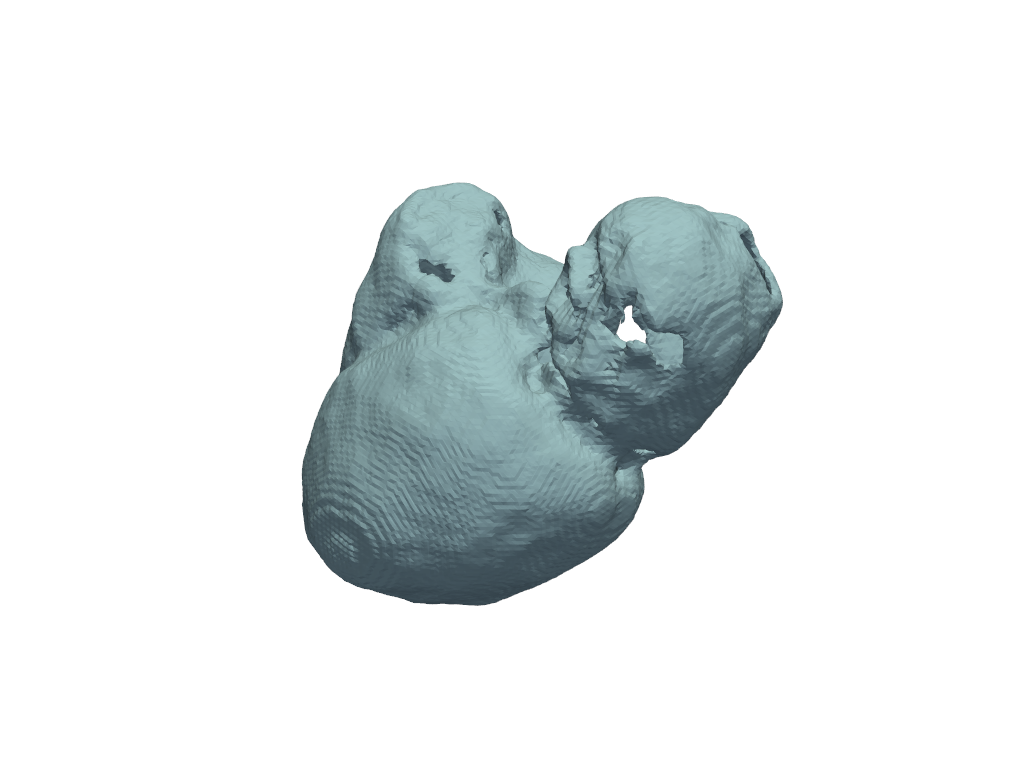

In [33]:
import pymeshfix
import pyvista as pv

# # Create object from vertex and face arrays
meshfix = pymeshfix.MeshFix(verts, faces)

# Plot input
# meshfix.plot()

# Repair input mesh
meshfix.repair()

# Access the repaired mesh with vtk
mesh = meshfix.mesh

# Or, access the resulting arrays directly from the object
# meshfix.v # numpy np.float64 array
# meshfix.f # numpy np.int32 array

# View the repaired mesh (requires vtkInterface)
meshfix.plot()

# Save the mesh
meshfix.save('results/Pix2Vox/predicted_005.ply')

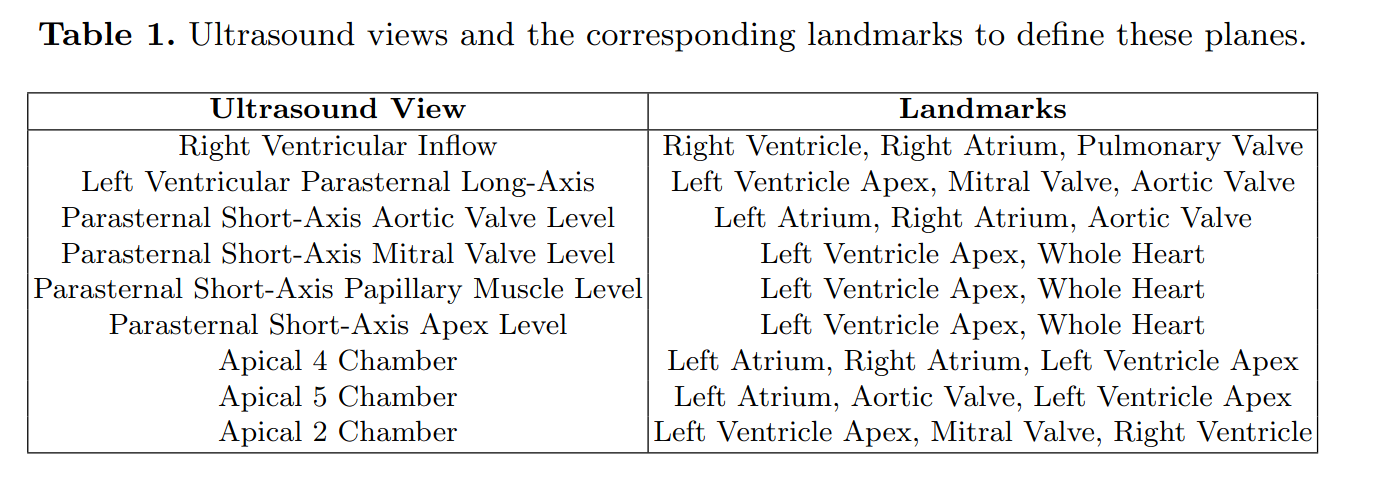


In [34]:
SELECTED_VIEWS = ['rv_inflow', 'lv_plax', 'psax_aortic', 
                  'psax_mv','psax_pm', 'psax_lower', 
                  'a4c', 'a5c', 'a2c']

In [82]:
new_imgs = []
for path in imgs_paths:
    print(np.unique(cv2.imread(path, 0)))
    new_imgs.append(cv2.imread(path, 0))

[  0  23  44 166]
[  0  23  33  41  65  74 105 166]
[  0  23  47  62 121 166]
[  0  23 166]
[  0  23 166]
[  0  23 166]
[  0  23  32  41  64  72 100 107 157 166]
[  0  23  47  62 121 166]
[  0  23  44  69  89  96 155 166]


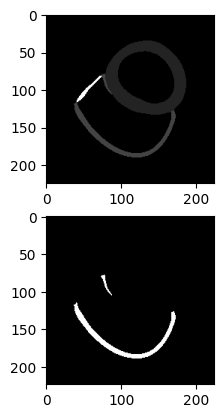

In [86]:
plt.subplot(211); plt.imshow(new_imgs[0], 'gray')
plt.subplot(212); plt.imshow(np.where(new_imgs[0] == 44, 255, 0), 'gray')